In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, silhouette_score, recall_score, precision_score, make_scorer,roc_auc_score, f1_score, precision_recall_curve, f1_score,r2_score,plot_confusion_matrix
from sklearn import svm
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.inspection import PartialDependenceDisplay
import shap 
import category_encoders as ce
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import scikitplot as skplt

from multiprocessing import Process,Pool
import copy
import time
import os
import threading
from pathlib import Path
from joblib import dump, load
import re
import warnings

In [2]:
shap.initjs()

In [3]:
target = 'C_SEV'


if target == 'C_SEV':
    numeric_features = ['C_VEHS', 'V_AGE','P_AGE','C_PERS']
    categorical_features = ['C_MNTH','C_WDAY','C_HOUR','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF','P_SEX','P_SAFE','V_TYPE']
    file = 'crash_transformed_c_sev.csv'
    one_hot_categories = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'P_SEX']
    target_categories = ['C_CONF', 'C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','P_SAFE']
else:
    target = 'P_ISEV'
    numeric_features = ['C_VEHS', 'V_AGE','P_AGE']
    #numeric_features = ['C_VEHS', 'A_DAGE', 'A_PERS', 'A_VAGE']
    #categorical_features = ['C_MNTH', 'C_WDAY', 'A_CHUR', 'C_CONF', 'C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','A_DSEX','P_SAFE']
    categorical_features = ['C_MNTH','C_WDAY','C_HOUR','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF','P_SEX','P_PSN','P_SAFE','P_USER','V_TYPE']
    file = 'crash_transformed_p_isev.csv'
    one_hot_categories = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'P_SEX']
    target_categories = ['C_CONF', 'C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','P_SAFE','P_PSN','P_USER']
dtypes = {}
for feature in numeric_features:
    dtypes[feature] = 'float' 
for feature in categorical_features:
    dtypes[feature] = 'str' 

#data = pd.read_csv('crash_transformed.csv',dtype=dtypes)
data = pd.read_csv(f'./data/{file}',dtype=dtypes)

#data[categorical_features] = data[categorical_features].astype('category')
#data[numeric_features] = data[numeric_features].astype('float64')

In [4]:
data.dtypes.to_dict()

{'C_MNTH': dtype('O'),
 'C_WDAY': dtype('O'),
 'C_HOUR': dtype('O'),
 'C_SEV': dtype('int64'),
 'C_VEHS': dtype('float64'),
 'C_CONF': dtype('O'),
 'C_RCFG': dtype('O'),
 'C_WTHR': dtype('O'),
 'C_RSUR': dtype('O'),
 'C_RALN': dtype('O'),
 'C_TRAF': dtype('O'),
 'V_TYPE': dtype('O'),
 'P_SEX': dtype('O'),
 'P_AGE': dtype('float64'),
 'P_SAFE': dtype('O'),
 'C_PERS': dtype('float64'),
 'V_AGE': dtype('float64')}

In [5]:
X = data.drop(target,axis=1)
y = data[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
print(f'Registros Sin muertes {len(y_train[y_train==0])}')
print(f'Registros Con muertes {len(y_train[y_train==1])}')

Registros Sin muertes 3051543
Registros Con muertes 45473


In [8]:
def subsample_data(X,y):
    y_2 = resample(y[y==0], replace = True, n_samples = len(y[y==1]), random_state = 12345)
    y_resampled = pd.concat([y[y==1],y_2])
    data_resampled = X.join(y_resampled)
    data_resampled = data_resampled.dropna(subset=[y.name])
    _y = data_resampled[y.name].astype('int8')
    _x = data_resampled.drop(target,axis=1)
    return _x,_y

X_train,y_train = subsample_data(X_train,y_train)
X_train.shape

(90946, 16)

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_transformer_one_hot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer_target = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', ce.CatBoostEncoder())])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat1', categorical_transformer_one_hot, one_hot_categories),
        ('cat2', categorical_transformer_target, target_categories)])

In [11]:
#SelectFromModel(, threshold = 0.08)
classifiers = [LinearRegression(n_jobs=-1),
               LogisticRegression(C=1, penalty='l1', solver='liblinear',n_jobs=-1),
               RandomForestClassifier(n_jobs=-1),
               XGBClassifier(scale_pos_weight=1,
                             tree_method='gpu_hist',
                             gpu_id=0,
                             n_jobs=-1),
               LGBMClassifier()]#,
               #svm.SVC(kernel='linear',cache_size=20240,class_weight={1:100,2:1})]

In [12]:
pipelines = []
        
for classifier in classifiers:
    pipelines.append(make_pipeline(preprocessor,classifier,memory='./cache'))
    #pipelines.append(make_pipeline(preprocessor,PCA(),classifier,memory='./cache'))



def fit_pipeline(pipe,xtrain,xtest,ytrain,ytest):
    model_folder = './saved_models/'
    file_name = re.sub('[^a-zA-Z0-9 \n\.]', '', list(pipe.named_steps.keys())[-1])
    print(file_name)
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    if not Path(model_folder+file_name+'.joblib').is_file():
        start_time = time.time()
        logs = 'Model '+file_name+'\n'
        print('Training started')
        pipe.fit(xtrain, ytrain)
        predictions = pipe.predict(xtest)
        execution_time = (time.time() - start_time)
        data = {'y_Actual': ytest,'y_Predicted': predictions}
        df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
        confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
        logs = logs + f'train duration {execution_time} \n'
        logs = logs + f'Confusion matrix \n {confusion_matrix.to_string()} \n'
        r2score = r2_score(ytest, predictions)
        logs = logs + f'r2 score: {r2score}\n'
        try:
            f1score = f1_score(ytest, predictions,average='weighted')
            logs = logs + f'f1 score:  {f1score}\n '
        except:
            pass
        print(logs)
        with open('./logs/'+file_name+'.txt', 'w') as f:
            f.write(logs)
        dump(pipe, model_folder+file_name+'.joblib')
    print('Model trained')


In [13]:
parallel = True

In [14]:
if parallel:
    import multiprocessing
    from workers import _fit_pipeline
    print('Parallel')
    params = [(pipe,X_train, X_test, y_train, y_test) for pipe in pipelines]
    #%%
    if __name__ ==  '__main__': 
        pool = multiprocessing.Pool()
        pool.starmap(_fit_pipeline, params)
        pool.close()
        pool.join()
else:
    print("Secuential")
    for pipe in pipelines:
        fit_pipeline(pipe,X_train, X_test, y_train, y_test)


Parallel


In [15]:

param_grid = { 
    'classifier__n_estimators': [100,200,300,600], 
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [10,20,30,40],
    'classifier__criterion' : ['gini','entropy'],
    'classifier__class_weight':[{1:1,0:1},{1:1.2,0:1},{1:1.5,0:1},{1:1.7,0:1}]} 

modelname = 'randomforestclassifier'

clf = load(f'./saved_models/{modelname}.joblib') 
clf.steps.append(('classifier',clf.steps.pop(-1)[1]))

cf_file = './saved_models/cv.joblib'

if not Path(cf_file).is_file():
    CV = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1)
    start_time = time.time()
    CV.fit(X_train, y_train)  
    print(f'training duration{(time.time() - start_time)} s')
    dump(CV, cf_file)
else:
    CV = load(cf_file)

print(CV.best_params_)    
print(CV.best_score_)


{'classifier__class_weight': {1: 1.2, 0: 1}, 'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__max_features': 'auto', 'classifier__n_estimators': 600}
0.7534141692539216


In [16]:
predictions = CV.predict(X_test)
prob_predictions = CV.predict_proba(X_test)

In [17]:
print(f'Recall: {recall_score(y_test, predictions,average="weighted")}')
print(f'Precision: {precision_score(y_test, predictions,average="weighted")}')
print(f'F1 score: {f1_score(y_test,predictions,average="weighted")}')

Recall: 0.7693883402604313
Precision: 0.9810770895180501
F1 score: 0.8564627001636742


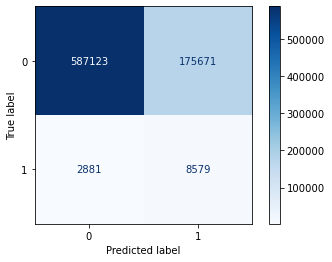

In [18]:
plot_confusion_matrix(CV, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)

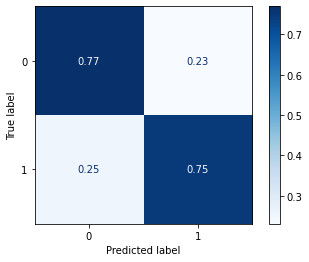

In [19]:
plot_confusion_matrix(CV, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

Best Threshold=0.490635, G-Mean=0.760


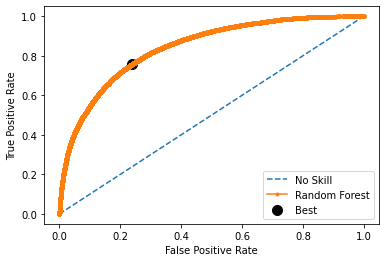

In [20]:
# keep probabilities for the positive outcome only
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [21]:
CV.best_estimator_.named_steps['classifier'].feature_importances_

array([3.56243412e-02, 3.32082824e-02, 4.93759598e-02, 2.09146524e-02,
       4.02629320e-03, 3.74978836e-03, 3.75455211e-03, 3.59698594e-03,
       3.71366249e-03, 3.67386452e-03, 4.17156956e-03, 4.25018897e-03,
       3.89686481e-03, 3.85627232e-03, 3.89395861e-03, 4.01477276e-03,
       3.15099704e-06, 4.81848746e-03, 4.76767162e-03, 4.84506281e-03,
       4.99288325e-03, 5.20211369e-03, 5.12652076e-03, 5.16855029e-03,
       1.10481057e-05, 1.09110063e-02, 5.40483712e-03, 8.11131737e-03,
       5.84500383e-03, 1.16113252e-03, 1.04368696e-02, 1.36948211e-02,
       2.43972099e-03, 2.12330360e-01, 7.64774476e-02, 5.09965131e-02,
       5.20641447e-02, 6.60200150e-02, 8.92993890e-02, 8.19258234e-02,
       9.22240995e-02])

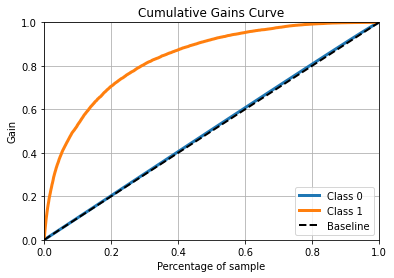

In [22]:
skplt.metrics.plot_cumulative_gain(y_test, prob_predictions)
plt.show()

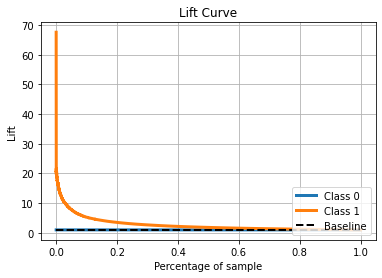

In [23]:
skplt.metrics.plot_lift_curve(y_test, prob_predictions)
plt.show()

In [24]:
explainer = shap.TreeExplainer(CV.best_estimator_.named_steps['classifier'])
test_data,_ = subsample_data(X_test,y_test)
x_test_transformed = CV.best_estimator_.named_steps['columntransformer'].transform(test_data)

In [27]:
estimator_columns = numeric_features + list(CV.best_estimator_.named_steps['columntransformer'].transformers_[1][1].named_steps['encoder'].get_feature_names(one_hot_categories))+target_categories
test_data = pd.DataFrame(x_test_transformed,columns=estimator_columns).sample(100)
test_data

,C_VEHS,V_AGE,P_AGE,C_PERS,C_MNTH_01,C_MNTH_02,C_MNTH_03,C_MNTH_04,C_MNTH_05,C_MNTH_06,...,P_SEX_M,P_SEX_missing,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SAFE
2952,-0.350623,-0.464938,-0.562329,-0.644710,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.612813,0.624696,0.544704,0.464527,0.451483,0.589945,0.457476,0.448290
18176,-0.067863,-0.111407,2.302586,-0.644710,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.382207,0.362381,0.544704,0.501259,0.451483,0.233327,0.364715,0.676614
19215,-0.067863,-0.995234,-1.218873,-0.644710,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.187968,0.624696,0.485397,0.501259,0.451483,0.589945,0.457476,0.448290
18431,-0.067863,1.656247,0.153900,-0.644710,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.892786,0.362381,0.485397,0.501259,0.451483,0.233327,0.457476,0.448290
7477,-0.067863,-0.818469,1.108871,-0.644710,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.451377,0.624696,0.485397,0.693490,0.451483,0.589945,0.734432,0.465367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,-0.350623,-1.348765,-0.622015,0.029342,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.694917,0.624696,0.553044,0.545275,0.559893,0.589945,0.457476,0.465367
9648,-0.067863,0.772420,1.884786,-0.644710,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.382207,0.362381,0.455079,0.464527,0.698733,0.233327,0.457476,0.448290
17802,0.214898,-0.111407,-1.039815,0.029342,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.511980,0.624696,0.485397,0.501259,0.698733,0.800885,0.457476,0.448290
21763,0.214898,0.595655,1.108871,0.029342,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.187968,0.362381,0.485397,0.501259,0.559893,0.589945,0.457476,0.448290


In [28]:
shap_values =  explainer.shap_values(test_data)

In [29]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], test_data.iloc[0,:])

In [30]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], features=test_data.iloc[:100, :])